In [1]:
import matplotlib.pyplot as plt
%matplotlib notebook
import numpy as np
import pandas as pd
import pickle

import xmeos
from xmeos import models
from xmeos import datamod
CONSTS = models.CONSTS
import copy

from collections import OrderedDict

In [2]:
analysis_file = 'data/analysis.pkl'
with open(analysis_file, 'rb') as f:
    analysis = pickle.load(f)

In [3]:
datamodel = analysis['datamodel']
data = datamodel['data']
eos_mod = datamodel['eos_mod']

In [4]:
T0 = eos_mod.get_refstate()['T0']


In [5]:
# Extract reference isotherm and roughly estimate 
#   compression parameters using interpolation

S0 = 0 # Ignore absolute entropy for simplicity

kind_thermal='Debye'
kind_thermal='ConstHeatCap'
kind_gamma = 'GammaFiniteStrain'
kind_compress = 'Vinet'
compress_path_const = 'S'
# compress_path_const = 'T'
ref_energy_type='E0'
# ref_energy_type='F0'
natom = 1
molar_mass = (24.31+28.09+3*16.0)/5.0 # g/(mol atom)

eos_mod_mgd = models.MieGruneisenEos(
    kind_thermal=kind_thermal, kind_gamma=kind_gamma, 
    kind_compress=kind_compress, compress_path_const=compress_path_const,
    natom=natom, ref_energy_type=ref_energy_type)

eos_mod_mgd.ndof=3

eos_mod_mgd.refstate.ref_state['T0'] = T0
eos_mod_mgd.set_param_values(S0, param_names='S0')

In [6]:
datamodel_mgd = datamod.init_datamodel(data, eos_mod_mgd)

In [7]:
datamodel_mgd['eos_mod']

ThermalEos(kind_thermal='ConstHeatCap', kind_gamma='GammaFiniteStrain', kind_compress='Vinet', compress_path_const='S', natom=1, model_state={'param_names': ['V0', 'K0', 'KP0', 'gamma0', 'gammap0', 'theta0', 'Cvlimfac', 'S0', 'E0'], 'param_values': [100.0, 150.0, 4.0, 0.5, -2.0, nan, 1.0, 0.0, 0.0]}, )

In [8]:
compress_param_names0 = ['V0','K0','KP0','E0']
compress_param_names = ['V0','K0','KP0','E0']
gamma_param_names = ['gamma0', 'gammap0']

compress_param_vals = eos_mod.get_param_values(
    param_names=compress_param_names0)
gamma_param_vals = eos_mod.get_param_values(
    param_names=gamma_param_names)

eos_mod_mgd.set_param_values(param_names=compress_param_names,
                             param_values=compress_param_vals)
eos_mod_mgd.set_param_values(param_names=gamma_param_names,
                             param_values=gamma_param_vals)

In [9]:
tbl = datamodel_mgd['data']['table']
err_scale = datamodel['err_scale']
# tbl['E']

In [10]:
resid=datamod.calc_resid(datamodel_mgd)
residP = resid[0:79]
residE = resid[79:]

In [11]:
residP_a = (eos_mod_mgd.press(tbl['V'],tbl['T'])-tbl['P'])/datamodel['err_scale']['P']
residE_a = (eos_mod_mgd.internal_energy(tbl['V'],tbl['T'])-tbl['E'])/datamodel['err_scale']['E']
# residE_a-residE
# residP_a-residP

In [12]:
datamodel_mgd['eos_mod']

ThermalEos(kind_thermal='ConstHeatCap', kind_gamma='GammaFiniteStrain', kind_compress='Vinet', compress_path_const='S', natom=1, model_state={'param_names': ['V0', 'K0', 'KP0', 'gamma0', 'gammap0', 'theta0', 'Cvlimfac', 'S0', 'E0'], 'param_values': [12.949250450702516, 13.200057209910977, 8.238371638327022, 0.18994317306925565, -1.9402437274750277, nan, 1.0, 0.0, -20.595341043999703]}, )

In [13]:
# datamodel_mgd

In [14]:
eos_mod_mgd.set_param_values(param_names=['Cvlimfac'],param_values=[1.55])

In [15]:
display(eos_mod_mgd.get_params())
display(eos_mod_mgd.get_refstate())

OrderedDict([('V0', 12.949250450702516),
             ('K0', 13.200057209910977),
             ('KP0', 8.2383716383270222),
             ('gamma0', 0.18994317306925565),
             ('gammap0', -1.9402437274750277),
             ('theta0', nan),
             ('Cvlimfac', 1.55),
             ('S0', 0.0),
             ('E0', -20.595341043999703)])

{'P0': 0, 'T0': 3000}

In [16]:
T0 = eos_mod_mgd.get_refstate()['T0']
V0 = eos_mod_mgd.get_params()['V0']
eos_mod_mgd.internal_energy(V0,T0)
# eos_mod_mgd.press(V0,T0)

array([-20.59534104])

In [17]:
# datamodel_mgd['data']['exp_constraint']=None

In [18]:
fit_calcs = ['compress','gamma','refstate','thermal']
fix_params = ['S0','theta0']

In [19]:
datamod.select_fit_params(datamodel_mgd, fit_calcs, fix_params=fix_params)

In [20]:
datamodel_mgd['fit_params']

['V0', 'K0', 'KP0', 'gamma0', 'gammap0', 'E0', 'Cvlimfac']

In [21]:
datamod.fit(datamodel_mgd)
datamod.fit(datamodel_mgd, apply_bulk_mod_wt=True, wt_vol=.5)

In [22]:
display('R2fit = ', datamodel_mgd['posterior']['R2fit'])
display('Model Residual Error = ', datamodel_mgd['posterior']['fit_err'])
display(datamodel_mgd['posterior']['param_tbl'])

'R2fit = '

{'E': 0.99937862408610512, 'P': 0.99941381877400581, 'V': 0.99867658602546416}

'Model Residual Error = '

{'E': 0.0093354138181643877,
 'P': 1.2538123833617307,
 'V': 0.097496344816823094}

,name,value,error
0,V0,13.135910,0.022980
1,K0,12.991180,0.251849
2,KP0,8.490653,0.057560
3,gamma0,0.214248,0.007668
4,gammap0,-1.744316,0.037815
5,E0,-20.595372,0.002401
6,Cvlimfac,1.549513,0.004379


In [23]:
def fit_param_symbols():
    param_tex_sym = OrderedDict()
    param_tex_sym['V0'] = r"$V_0$"
    param_tex_sym['K0'] = r"$K_0$"
    param_tex_sym['KP0'] = r"$K'_0$"
    param_tex_sym['E0'] = r"$E_0$"
    param_tex_sym['gamma0'] = r"$\gamma_0$"
    param_tex_sym['gammap0'] = r"$\gamma'_0$"
    param_tex_sym['Cvlimfac'] = r"$C_V^\textrm{lim}$"
    
    return param_tex_sym


param_tex_sym = fit_param_symbols()

<IPython.core.display.Javascript object>


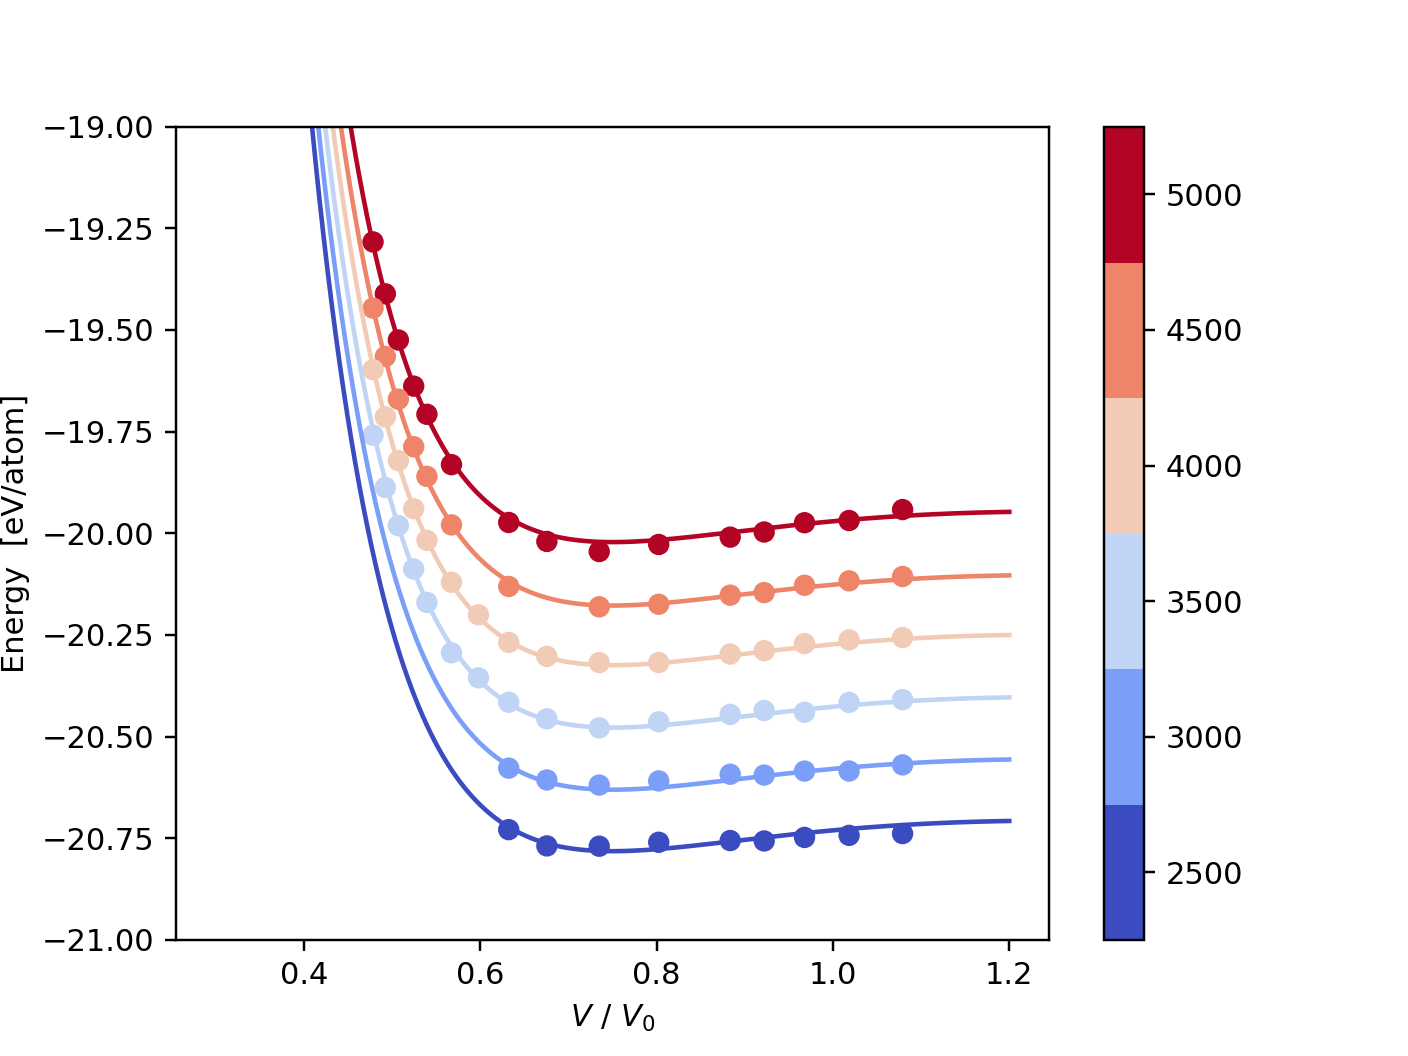

(-21, -19)

In [24]:
tbl = datamodel_mgd['data']['table']

Tlbl = data['T_labels']
delT = Tlbl[1]-Tlbl[0]
clims = [Tlbl[0]-delT/2,Tlbl[-1]+delT/2]
cmap = plt.get_cmap('coolwarm',len(Tlbl))

T0 = eos_mod_mgd.get_refstate()['T0']
V0 = eos_mod_mgd.get_params()['V0']
Vmod = V0*np.linspace(.3,1.2,1001)

plt.figure()
for iT in data['T_avg']:
    icol = cmap((iT-clims[0])/(clims[1]-clims[0]))
    plt.plot(Vmod/V0, eos_mod_mgd.internal_energy(Vmod,iT), '-', color=icol)
    
plt.scatter(tbl['V']/V0,tbl['E'],c=tbl['T'], cmap=cmap)
plt.xlabel(r'$V$ / $V_0$')
plt.ylabel(r'Energy  [eV/atom]')
cbar = plt.colorbar()
plt.clim(clims)
cbar.set_ticks(Tlbl)
plt.ylim(-21,-19)

<IPython.core.display.Javascript object>


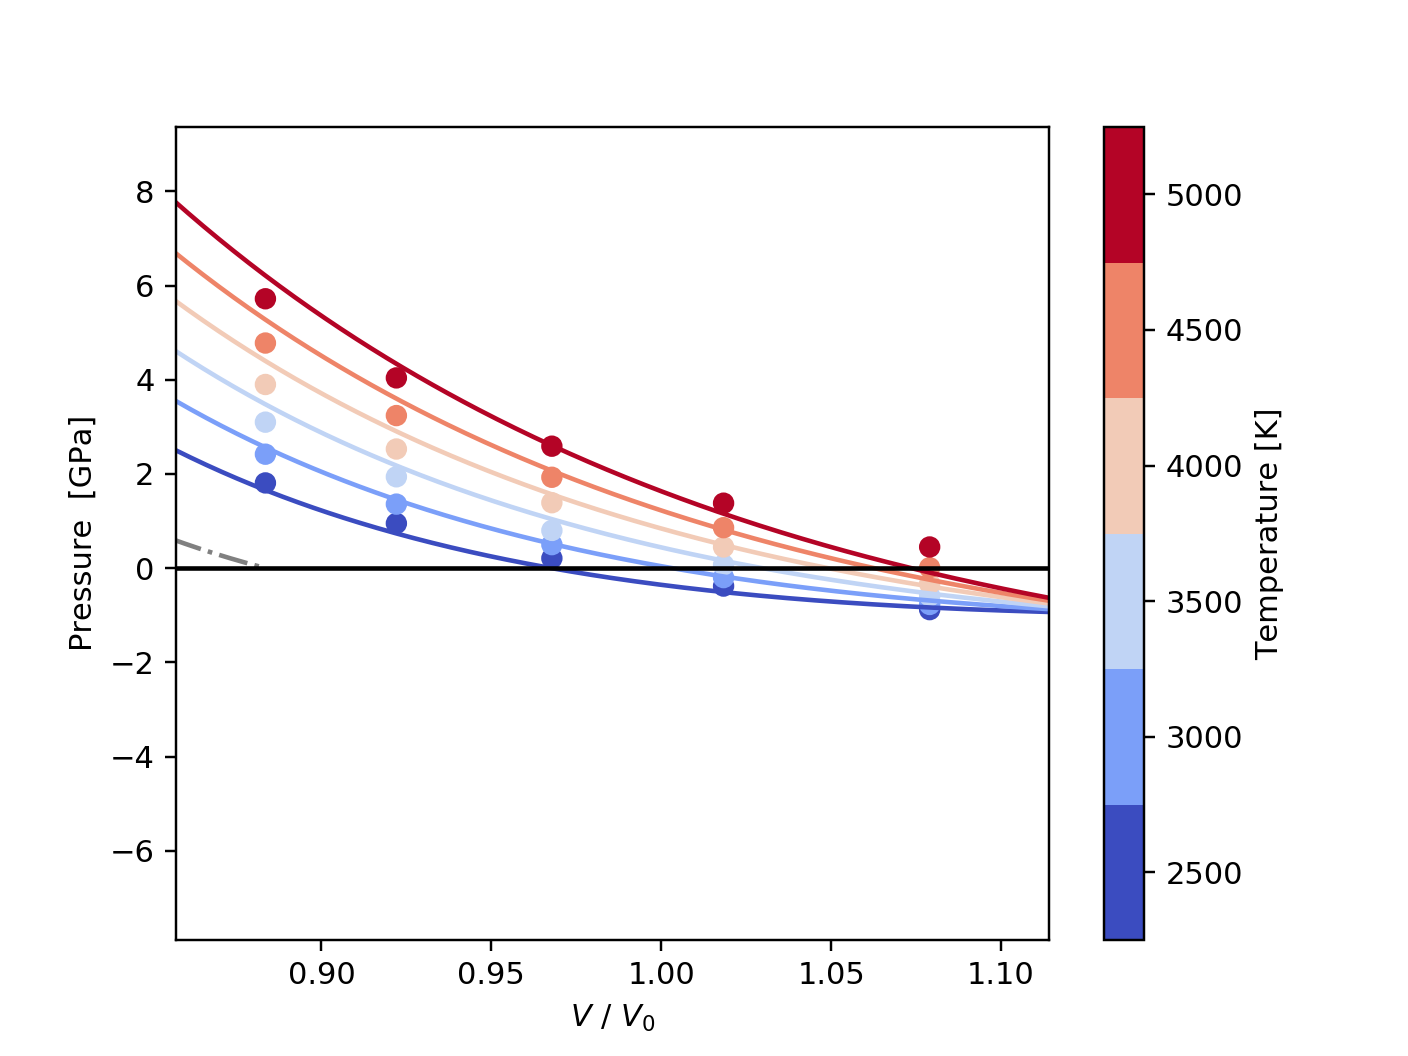

In [25]:
plt.figure()
for iT in data['T_avg']:
    icol = cmap((iT-clims[0])/(clims[1]-clims[0]))
    plt.plot(Vmod/V0, eos_mod_mgd.press(Vmod,iT), '-', color=icol)


Tbnd = 1773
Tbnd = 1673
Pbnd = eos_mod_mgd.press(Vmod,Tbnd)
# indbnd = np.argmin(Pbnd)
indbnd = np.argmin(Pbnd**2)


plt.plot(Vmod[:indbnd]/V0, Pbnd[:indbnd],'-.',color=[.5,.5,.5])
    
plt.scatter(tbl['V']/V0,tbl['P'],c=tbl['T'], cmap=cmap)
plt.clim(clims)
plt.xlabel(r'$V$ / $V_0$')
plt.ylabel(r'Pressure  [GPa]')
cbar = plt.colorbar(label='Temperature [K]')
cbar.set_ticks(Tlbl)

#plt.ylim(-2,15);
plt.plot(Vmod/V0,0*Vmod,'k-')

In [26]:
Tlbl = [2000,2250,2500,2750,3000,3250,3500]
delT = Tlbl[1]-Tlbl[0]
clims = [Tlbl[0]-delT/2,Tlbl[-1]+delT/2]
Tfoot_grid = Tlbl
Pgrid = np.arange(0,550.1,1)
eos_mod.apply_electronic = False
Vad_grid, Tad_grid = eos_mod.adiabatic_path_grid(Tfoot_grid, Pgrid)

Vad_grid_mgd, Tad_grid_mgd = eos_mod_mgd.adiabatic_path_grid(Tfoot_grid, Pgrid)

<IPython.core.display.Javascript object>


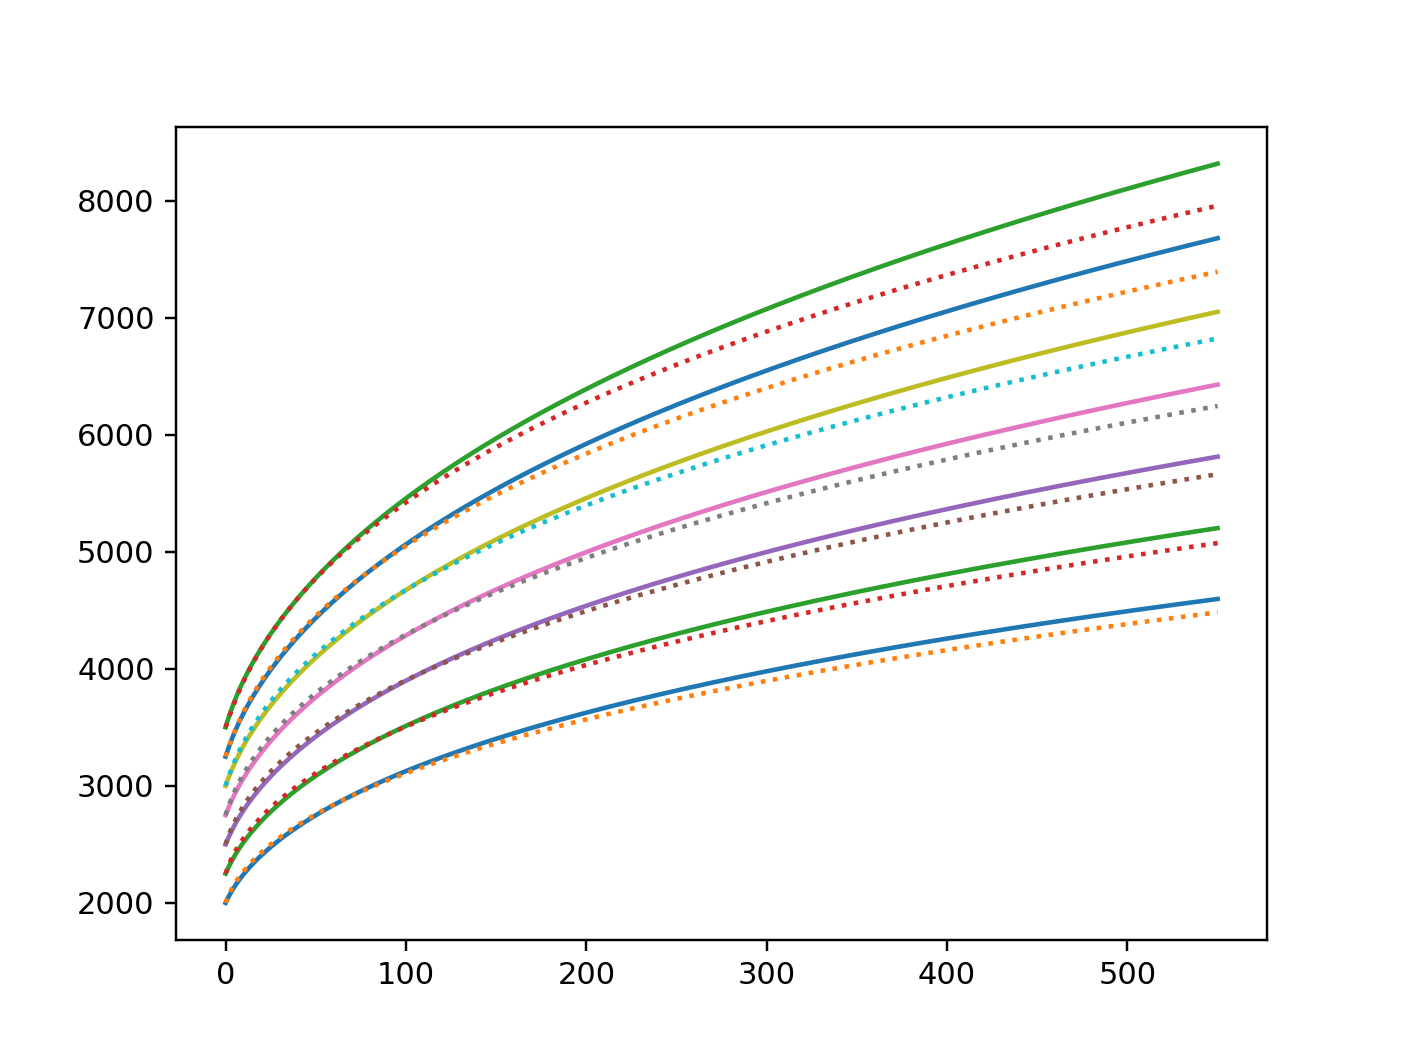

In [27]:
plt.figure()

for Tad, Tad_mgd in zip(Tad_grid, Tad_grid_mgd):
    plt.plot(Pgrid,Tad,'-')
    plt.plot(Pgrid,Tad_mgd,':')